# General E(2)-Equivariant Steerable CNNs  -  Hands-on tutorial

We start by importing the necessary packages. The user typically only needs to interact with the high level functionalities provided in the subpackages `e2cnn.gspaces` and `e2cnn.nn`.

In [1]:
import torch

from e2cnn import gspaces
from e2cnn import nn

## Basic Examples

Throughout the whole tutorial we consider data which is given as a signal on the plane $\mathbb{R}^2$, for instance images.
We formalize such signals as **feature vector fields**, i.e. functions
$$ f: \mathbb{R}^2 \to \mathbb{R}^c $$

which assign a $c$-dimensional feature vector $f(x)\in\mathbb{R}^c$ to each spatial position $x\in\mathbb{R}^2$.

The plane $\mathbb{R}^2$ has many symmetries which can be exploited by equivariant CNNs.
Our library focuses on exploiting **isometries**, i.e. distance preserving transformations.
Specifically for $\mathbb{R}^2$, the isometries are formalized by the **Euclidean group** $E(2)$ which consists of *translations*, *rotations* and *reflections*.

E(2) steerable CNNs can adaptively choose the level of symmetries which they respect.
Since we are choosing a *convolutional* network design, all models will be equivariant under translations.
The open choice is therefore in the level of point symmetries (here reflections and rotations) which are being considered.
All of these choices are subgroups $G\leq O(2)$ of the orthogonal group.
For simplicity, we will in the following consider a the cyclic subgroup $C_4$, which models the $4$ *rotations* which are multiples of $\frac{\pi}{2}$, that is, $\big\{0, \frac{\pi}{2}, \pi, \frac{3\pi}{2}\big\}$.
Because these are perfect symmetries of the grid, transforming an image with this group does not require any interpolation.

We determine both the **point group** and its **action on the space** by instantiating a subclass of `gspace.GSpace`.
For the rotational action of $G=C_4$ on $\mathbb{R}^2$ this is done by:

In [2]:
r2_act = gspaces.Rot2dOnR2(N=4)

Having specified the symmetry transformation on the *base space* $\mathbb{R}^2$, we next need define how the signals sampled on this space transform under the action of $G$.
This transformation law of feature fields is implemented as a **FieldType**.

Each single feature space (layer) of E(2) steerable CNNs has its own transformation law which the user needs to specify.
The transformation law of the network *input* and *output* is typically determined by the inference task.

As a trivial, yet important example we consider the case of gray-scale images as network input.
A rotation of a gray-scale image is performed by moving each pixel to a new position without changing their intensity values.
The invariance of the scalar pixel values under rotations is modeled by the **trivial representation** $\rho:G\to\operatorname{GL}(1),\ g\mapsto(1)$ of $G$ and identifies them as **scalar fields**.
Formally, a scalar field is a function $f: \mathbb{R}^2 \to \mathbb{R}$ mapping to a feature vector with $c=1$ channels.
A rotation by an angle $\theta \in C_4$ transforms this scalar field as

$$ \big[\mathcal{R}_{\theta}\, f\big](x)
   \ :=\ \rho(\theta)\,f\big(\psi(-\theta)x\big)
   \ =\ 1\cdot f\big(\psi(-\theta)x\big)
   \ =\ f\big(\psi(-\theta)x\big),$$

where $\mathcal{R}$ is the rotation operator acting on the field and $\psi(\theta)\in SO(2)$ is a rotation matrix.

We instantiate the `nn.FieldType` modeling a gray-scale image by passing it the `gspaces.GSpace` instance and the trivial representation.
The latter is passed as a *list of representations* which allows for feature spaces that comprise multiple independent feature fields as used in the hidden layers later on.

In [3]:
feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])

In [4]:
r2_act.trivial_repr

C4|irrep_0:1,1,1.0

When we build a model **equivariant** to a group $G$, we require that the output produced by the model transforms consistently when the input transforms under the action of an element $g \in G$.
For a function $F$ (e.g. a neural network), the **equivariance constraint** requires:

$$ \mathcal{T}^\text{out}_g \big[F(x)\big]\ =\ F\big(\mathcal{T}^\text{in}_g[x]\big) \quad \forall g\in G$$

where $\mathcal{T}^\text{in}_g$ is the transformation of the input by the group element $g$ while $\mathcal{T}^\text{out}_g$ is the transformation of the output by the same element.
We have already defined $\mathcal{T}^\text{in}$ by the *field type* `feat_type_in`. 
The transformation law $\mathcal{T}^\text{out}$ of the output of the first layer is similarly chosen by defining an instance `feat_type_out` of `nn.FieldType`.

Instead of scalar feature fields, we often choose so called **regular feature fields** $f:\mathbb{R}^2\to\mathbb{R}^{|G|}$ in the hidden layers of the model.
These fields correspond to *group convolutions* and are empirically found to work best in most cases.
Regular feature fields associate a feature vector of dimensionality equal to the cardinality of $G$, in our case $|C_4|=4$, to each point.
Their name comes from the fact that they transform under the **regular representation** $\rho_\text{reg}: G \to \operatorname{GL}\big(\mathbb{R}^{|G|}\big)$ of $G$ which acts via permutations.
Formally, a regular feature field thus transforms according to:

$$ \big[\mathcal{R}_{\theta}\, f\big](x)\ :=\ \rho_\text{reg}(\theta)\, f\big(\psi(-\theta)x\big)$$

A feature space consisting of a single regular feature field is instantiated as before, with the only difference that the trivial representation is replaced by the regular representation:

In [5]:
feat_type_out = nn.FieldType(r2_act, [r2_act.regular_repr])

In [6]:
print(r2_act.regular_repr)
print(3*[r2_act.regular_repr])
print(feat_type_out)

C4|regular:4,3,2.0
[C4|regular:4,3,2.0, C4|regular:4,3,2.0, C4|regular:4,3,2.0]
[4-Rotations: {regular}]


As deep feature spaces typically comprise multiple independent features (equal to channels for conventional CNNs), we usually choose multiple feature fields.
For example, we can use 3 regular fields.
The full feature space is in this case modeled as a *stacked* field $f: \mathbb{R}^2 \to \mathbb{R}^{3|G|}$ which transforms according to the **direct sum** of three regular representations:

$$\rho(\theta)
    \ =\ \rho_\text{reg}(\theta) \oplus \rho_\text{reg}(\theta) \oplus \rho_\text{reg}(\theta)
    \ =\ \begin{bmatrix} 
            \rho_\text{reg}(\theta) & 0 & 0 \\
            0 & \rho_\text{reg}(\theta) & 0 \\
            0 & 0 & \rho_\text{reg}(\theta) \\
          \end{bmatrix}
          \quad\in\ \mathbb{R}^{3N \times 3N}$$

Intuitively, the direct sum simply builds a block diagonal representation of the three regular representations, which implies that the three regular fields transform independently from each other.

We instantiate a `nn.FieldType` composed of 3 regular representations by passing the full field representation as a list of three regular representations:

In [13]:
feat_type_out = nn.FieldType(r2_act, 2*[r2_act.regular_repr])

In [14]:
print(feat_type_out)

[4-Rotations: {regular, regular}]


Once having defined how the input and output feature spaces should transform, we can build neural network functions as **equivariant modules**.
These are implemented as subclasses of an abstract base class `nn.EquivariantModule` which itself inherits from `torch.nn.Module`.

We start by instantiating a convolutional layer that maps between fields of types `feat_type_in` and `feat_type_out`:

In [15]:
conv = nn.R2Conv(feat_type_in, feat_type_out, kernel_size=3)

In [16]:
conv

R2Conv([4-Rotations: {irrep_0}], [4-Rotations: {regular, regular}], kernel_size=3, stride=1)

Each equivariant module has an input and output type.
As a function (`.forward()`), it *requires* its inputs to transform according to its input type and is guaranteed to return feature fields associated with its output type.
To prevent the user from accidentally feeding an incorrectly transforming input field into an equivariant module, we perform a dynamic type checking.
In order to do so, we define **geometric tensors** as data containers.
They are wrapping a *PyTorch* `torch.Tensor` to augment them with an instance of `FieldType`.

Let's build a few random 32x32 gray-scale images and wrap them into an `nn.GeometricTensor`:

In [18]:
feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])

In [22]:
x = torch.randn(4, 1, 32, 32)
x = nn.GeometricTensor(x, feat_type_in)

assert isinstance(x.tensor, torch.Tensor)

As usually done in *PyTorch*, an image or feature map is stored in a 4-dimensional array of shape BxCxHxW, where B is the batch-size, C is the number of channels and W and H are the spatial dimensions.

We can feed a geometric tensor to an equivariant module as we feed normal tensors in *PyTorch*'s modules:

In [10]:
y = conv(x)

We can verify that the output is indeed associated with the output type of the convolutional layer:

In [11]:
assert y.type == feat_type_out

Lets check whether the output transforms as described by the output type when the input transforms according to the input type.
The $G$-transformation of a geometric tensor is hereby conveniently done by calling `nn.GeometricTensor.transform()`.

In [12]:
# for each group element
for g in r2_act.testing_elements:
    # transform the input with the current group element according to the input type
    x_transformed = x.transform(g)
    
    # feed the transformed input in the convolutional layer
    y_from_x_transformed = conv(x_transformed)
    
    # the result should be equivalent to rotating the output produced in the 
    # previous block according to the output type
    y_transformed_from_x = y.transform(g)
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

Any network operation is required to be equivariant.
`e2cnn.nn` provides a wide range of equivariant network modules which guarantee this behavior.

As an example, we will next apply an **equivariant nonlinearity** to the output feature field of the convolution.
For the specific case of regular representations, any pointwise nonlinearity like *ReLUs* are equivariant.
Note that this is *not* the case for many other choices of representations / field types!

We instantiate a `e2cnn.nn.ReLU`, which, as an `nn.EquivariantModule`, requires to be informed about its input type to be able to perform the type checking.
Here we are passing `feat_type_out`, the output of the equivariant convolution layer, as input type.
It is not necessary to pass an output type to the nonlinearity since this is here determined by its input type.

In [14]:
relu = nn.ReLU(feat_type_out)

z = relu(y)

We can verify the equivariance again:

In [15]:
# for each group element
for g in r2_act.testing_elements:
    y_transformed = y.transform(g)
    z_from_y_transformed = relu(y_transformed)
    
    z_transformed_from_y = z.transform(g)
    
    assert torch.allclose(z_from_y_transformed.tensor, z_transformed_from_y.tensor, atol=1e-5), g

In *deep learning* we usually want to stack multiple layers to build a deep model.
As long as each layer is equivariant and consecutive layers are compatible, the equivariance property is preserved by induction.

The compatibility of two consecutive layers requires the output type of the first layer to be equal to the input type of the second layer.

In case we feed an input with the wrong type to a module, an error is raised:

In [16]:
layer1 = nn.R2Conv(feat_type_in, feat_type_out, kernel_size=3)
layer2 = nn.ReLU(feat_type_in) # the input type of the ReLU should be the output type of the convolution

x = nn.GeometricTensor(torch.randn(3, 1, 7, 7), feat_type_in)

try:
    y = layer2(layer1(x))
except AssertionError as e:
    print(e)

Error! the type of the input does not match the input type of this module


Simple deeper architectures can be built using a **SequentialModule**:

In [17]:
feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_act, 8*[r2_act.regular_repr])
feat_type_out = nn.FieldType(r2_act, 2*[r2_act.regular_repr])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
).eval()


As every layer is equivariant and consecutive layers are compatible, the whole model is equivariant.

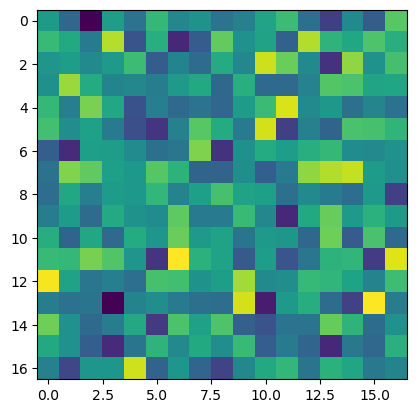

torch.Size([1, 1, 17, 17]) <class 'e2cnn.nn.geometric_tensor.GeometricTensor'>
0 <class 'int'>
x_transformed 1: torch.Size([1, 1, 17, 17]), <class 'e2cnn.nn.geometric_tensor.GeometricTensor'>


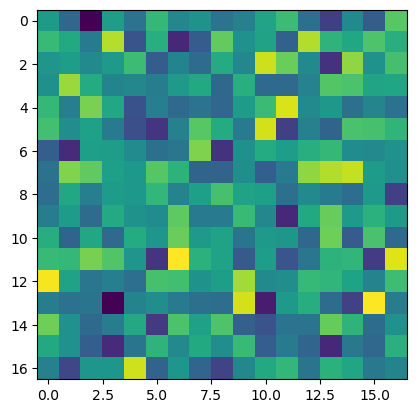

1 <class 'int'>
x_transformed 1: torch.Size([1, 1, 17, 17]), <class 'e2cnn.nn.geometric_tensor.GeometricTensor'>


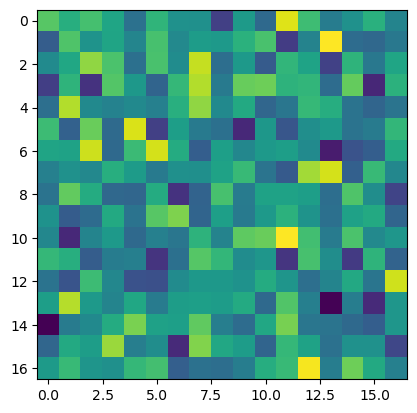

2 <class 'int'>
x_transformed 1: torch.Size([1, 1, 17, 17]), <class 'e2cnn.nn.geometric_tensor.GeometricTensor'>


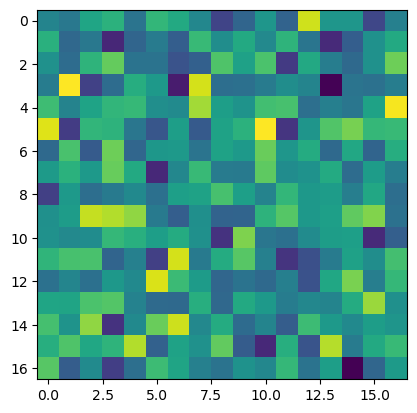

3 <class 'int'>
x_transformed 1: torch.Size([1, 1, 17, 17]), <class 'e2cnn.nn.geometric_tensor.GeometricTensor'>


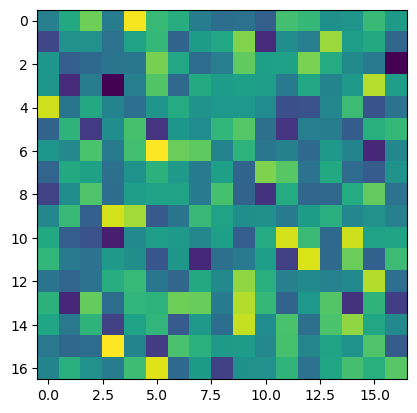

In [49]:
x = torch.randn(1, 1, 17, 17)
plt.imshow(x[0, 0, ...])
plt.show()
x = nn.GeometricTensor(x, feat_type_in)
print(x.shape, type(x))

y = model(x)

# for each group element
for g in r2_act.testing_elements:
    print(g, type(g))
    x_transformed = x.transform(g)
    print(f'x_transformed 1: {x_transformed.shape}, {type(x_transformed)}')
    plt.imshow(x_transformed.tensor[0, 0, ...])
    plt.show()
    y_from_x_transformed = model(x_transformed)
    
    y_transformed_from_x = y.transform(g)
    
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

Usually, at the end of the model we want to produce a single feature vector to use for classification.
To do so, it is common to pool over the spatial dimensions, e.g. through average pooling.

This produces (approximatively) translation-invariant feature vectors.

In [19]:
avgpool = nn.PointwiseAvgPool(feat_type_out, 11)

y = avgpool(model(x))

print(y.shape)

torch.Size([1, 8, 1, 1])


In our case, the feature vectors $f(x)\in\mathbb{R}^c$ associated to each point $x\in\mathbb{R}^2$ have a well defined transformation law.
The output of the model now transforms according to `feat_type_out` (here two $C_4$ regular fields, i.e. 8 channels).
For our choice of regular representations (which are permutation representations) the channels in the feature vectors associated to each point permute when the input is rotated.

In [20]:
for i in range(4):
    print(f'rotation by {i}*pi/2:', y.transform(i).tensor[0, ...].detach().numpy().squeeze())

rotation by 0*pi/2: [-0.2254 -0.2015 -0.1998 -0.1957  0.7871  0.7667  0.7883  0.7455]
rotation by 1*pi/2: [-0.1957 -0.2254 -0.2015 -0.1998  0.7455  0.7871  0.7667  0.7883]
rotation by 2*pi/2: [-0.1998 -0.1957 -0.2254 -0.2015  0.7883  0.7455  0.7871  0.7667]
rotation by 3*pi/2: [-0.2015 -0.1998 -0.1957 -0.2254  0.7667  0.7883  0.7455  0.7871]


Many learning tasks require to build models which are **invariant** under rotations.
We can compute invariant features from the output of the model using an **invariant map**.
For instance, we can take the maximum value within each regular field.
We do so using `nn.GroupPooling`:

In [21]:
invariant_map = nn.GroupPooling(feat_type_out)

y = invariant_map(avgpool(model(x)))

for i in range(4):
    print(f'rotation by {i}*pi/2:', y.transform(i).tensor[0, ...].detach().numpy().squeeze())

rotation by 0*pi/2: [-0.1957  0.7883]
rotation by 1*pi/2: [-0.1957  0.7883]
rotation by 2*pi/2: [-0.1957  0.7883]
rotation by 3*pi/2: [-0.1957  0.7883]


In [22]:
# for each group element
for g in r2_act.testing_elements:
    # rotated the input image
    x_transformed = x.transform(g)
    y_from_x_transformed = invariant_map(avgpool(model(x_transformed)))
    
    y_transformed_from_x = y # no .transform(g) needed since y should be invariant!
    
    # check that the output did not change
    # note that here we are not rotating the original output y as before
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-6), g

## Other Field Field Types

Besides scalar fields and regular fields, many other types of feature fields exist.

An example of practical importance are (tangent) **vector fields** which model for instance an optical flow fields.
On the plane, a vector field
$$f: \mathbb{R}^2 \to \mathbb{R}^2$$

associates a 2-dimensional (tangent) vector to each position.
Under rotations a vector field transforms by:
1. moving each vector to a new location
2. rotating the vectors themself

Together, the $G$-transformation of a vector field is therefore given by

$$ \big[\mathcal{R}_{\theta}\, f\big](x)
   \ :=\ \psi(\theta\,)\, f\big(\psi(-\theta)x\big),$$

that is, the representation $\rho(\theta)$ coincides with the rotation matrix
$\psi(\theta) = \begin{bmatrix} \cos(\theta) & \sin(\theta) \\ -\sin(\theta) & \cos(\theta) \end{bmatrix} \in SO(2)$ itself.

In general, the *type* of a feature field is in one-to-one correspondence with a choice of group representation $\rho:G\to\operatorname{GL}(\mathbb{R}^c)$ which describes how the feature vectors transform under the action of $G$.
`e2cnn` implements **irreducible representations** (irreps), **regular representations**, **quotient representations** and **induced representations** and provides an interface to construct any other choice of representation.
For more information we refer to the
[docs](https://quva-lab.github.io/e2cnn/api/e2cnn.group.html#representations)
and to Section 2.6 of our
[paper](https://arxiv.org/pdf/1911.08251.pdf).

For now, let us return to the example of (tangent) vector fields.
The rotation matrix representation $\psi$ of the cyclic group $G=C_4$ is identical to the *irreducible representation* (irrep) of $C_4$ with frequency $1$.
To specify a vector field as output, we therefore have to pass this irrep to the `FieldType`:

In [23]:
feat_type_out = nn.FieldType(r2_act, [r2_act.irrep(1)])

To verify that the output field indeed transforms as a *vector field*, we build a simple model which maps a random scalar field to a vector field and apply it to rotated versions of the scalar input field.
As expected, the output vector field transforms by moving each vector to a new position and rotating them.

/u/sradev/anaconda3/envs/caproject/lib/python3.9/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


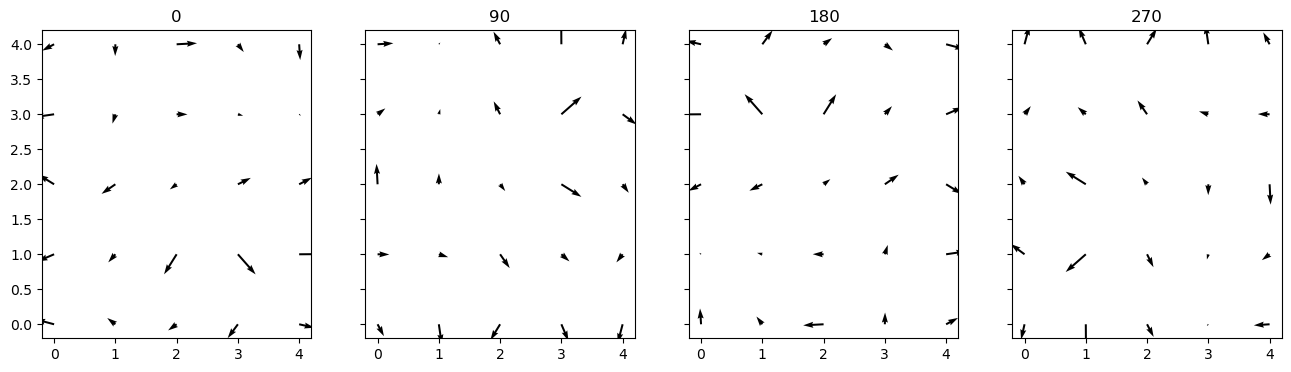

In [24]:
import matplotlib.pyplot as plt
import numpy as np

feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_act, 8*[r2_act.regular_repr])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
).eval()

S = 11
x = torch.randn(1, 1, S, S)
x = nn.GeometricTensor(x, feat_type_in)

fig, axs = plt.subplots(1, r2_act.fibergroup.order(), sharex=True, sharey=True, figsize=(16, 4))

X, Y = np.meshgrid(range(S-6), range(S-7, -1, -1))

# for each group element
for i, g in enumerate(r2_act.testing_elements):
    # transform the input
    x_transformed = x.transform(g)
    
    y = model(x_transformed)
    y = y.tensor.detach().numpy().squeeze()
    
    # plot the output vector field
    axs[i].quiver(X, Y, y[0, ...], y[1, ...], units='xy')
    axs[i].set_title(g*90)
    
plt.show()


We want to mention that vector fields can not be acted on by ReLU nonlinearities since this mapping would not be equivariant.
To see this, consider a vector $(1,0)^T$ which under a rotation by $\pi$ transforms to $(-1,0)^T$.
Acting on the former by a ReLU returns the vector itself while the latter will be projected to the origin such that all information of the feature is lost.

As an alternative, we can apply nonlinearities which solely act on the *norm* of the vector but not on its orientation.
Since the vectors rotate under the action of $C_4$, both operations commute which means that such
[NormNonLinearities](https://quva-lab.github.io/e2cnn/api/e2cnn.nn.html#normnonlinearity)
are equivariant for this field type.
For instance, we can apply so called *norm-ReLUs*:

In [25]:
norm_relu = nn.NormNonLinearity(feat_type_out, 'n_relu')

y = norm_relu(model(x))

for g in r2_act.testing_elements:
    x_transformed = x.transform(g)
    y_from_x_transformed = norm_relu(model(x_transformed))
    
    y_transformed_from_x = y.transform(g)
    
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

## Mixed Feature Fields

Our implementation allows for different feature field types in a feature space.
To achieve this, one simply has to pass a list of different representations when instantiating the `FieldType`.
As an example, let's build a feature field with 2 scalar fields, 2 regular fields and 1 vector field:

In [26]:
feat_type_out = nn.FieldType(r2_act, 2*[r2_act.trivial_repr] + 2*[r2_act.regular_repr] + 1*[r2_act.irrep(1)])

or equivalently

In [27]:
scalar_fields = nn.FieldType(r2_act, 2*[r2_act.trivial_repr])
regular_fields = nn.FieldType(r2_act, 2*[r2_act.regular_repr])
vector_field = nn.FieldType(r2_act, 1*[r2_act.irrep(1)])
feat_type_out = scalar_fields + regular_fields + vector_field

While the convolution layers can deal with mixed field types automatically, some additional care is needed when we apply non-linearities to mixed field types since these might not all allow for the same nonlinearity.

In the example above, we can apply ReLUs to the scalar and regular fields but we need to apply e.g. Norm-ReLUs to the vector field.
This can be achieved by using
[`MultipleModule`](https://quva-lab.github.io/e2cnn/api/e2cnn.nn.html#e2cnn.nn.MultipleModule)s
which split the input tensor into multiple branches, associating a different label to each of them.
Each branch is then being acted on by its own module, here an `nn.ReLU` for the `'relu'` branch and an `nn.NormNonLinearity` for the `'norm'` branch.
The output of the module is merged back together automatically.

In [28]:
relu = nn.ReLU(scalar_fields + regular_fields)
norm_relu = nn.NormNonLinearity(vector_field)

nonlinearity = nn.MultipleModule(
                    feat_type_out,
                    ['relu']*len(scalar_fields+regular_fields) + ['norm']*len(vector_field),
                    [(relu, 'relu'), (norm_relu, 'norm')]
)

We once again verify that this operation is $C_4$-equivariant:

In [29]:
model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
    nonlinearity,
).eval()

x = torch.randn(1, 1, 17, 17)
x = nn.GeometricTensor(x, feat_type_in)

y = model(x)

for g in r2_act.testing_elements:
    x_transformed = x.transform(g)
    y_from_x_transformed = model(x_transformed)
    
    y_transformed_from_x = y.transform(g)
    
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g